In [ ]:
!pip install tensorflow
!pip install q keras==2.4.1
!pip install segmentation_models
!pip install tensorflow_io

In [53]:
import tensorflow as tf

In [14]:
def Conv2D_Block(input_tensor , n_filters):
  x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(input_tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  
  x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  
  return x

In [15]:
def U_Net(img_tensor , n_filters = 16):
  conv1 = Conv2D_Block(img_tensor , n_filters * 1)
  pool1 = tf.keras.layers.MaxPooling2D((2 , 2))(conv1)
  pool1 = tf.keras.layers.Dropout(0.05)(pool1)
  
  conv2 = Conv2D_Block(pool1 , n_filters * 2)
  pool2 = tf.keras.layers.MaxPooling2D((2 , 2))(conv2)
  pool2 = tf.keras.layers.Dropout(0.05)(pool2)
  
  conv3 = Conv2D_Block(pool2 , n_filters * 4)
  pool3 = tf.keras.layers.MaxPooling2D((2 , 2))(conv3)
  pool3 = tf.keras.layers.Dropout(0.05)(pool3)
  
  conv4 = Conv2D_Block(pool3 , n_filters * 8)
  pool4 = tf.keras.layers.MaxPooling2D((2 , 2))(conv4)
  pool4 = tf.keras.layers.Dropout(0.05)(pool4)
  
  conv5 = Conv2D_Block(pool4 , n_filters * 16)
  
  pool6 = tf.keras.layers.Conv2DTranspose(n_filters * 8 , (3 , 3) , (2, 2) , padding = 'same')(conv5)
  pool6 = tf.keras.layers.concatenate([pool6 , conv4])
  pool6 = tf.keras.layers.Dropout(0.05)(pool6)
  conv6 = Conv2D_Block(pool6 , n_filters * 8)
  
  pool7 = tf.keras.layers.Conv2DTranspose(n_filters * 4 , (3 , 3) , (2 , 2) , padding = 'same')(conv6)
  pool7 = tf.keras.layers.concatenate([pool7 , conv3])
  pool7 = tf.keras.layers.Dropout(0.05)(pool7)
  conv7 = Conv2D_Block(pool7 , n_filters * 4)
  
  pool8 = tf.keras.layers.Conv2DTranspose(n_filters * 2 , (3 , 3) , (2 , 2) , padding = 'same')(conv7)
  pool8 = tf.keras.layers.concatenate([pool8 , conv2])
  pool8 = tf.keras.layers.Dropout(0.05)(pool8)
  conv8 = Conv2D_Block(pool8 , n_filters * 2)
  
  pool9 = tf.keras.layers.Conv2DTranspose(n_filters * 1 , (3 , 3) , (2 , 2) , padding = 'same')(conv8)
  pool9 = tf.keras.layers.concatenate([pool9 , conv1])
  pool9 = tf.keras.layers.Dropout(0.05)(pool9)
  conv9 = Conv2D_Block(pool9 , n_filters * 1)
  
  output = tf.keras.layers.Conv2D(1 , (1 , 1) , activation = 'sigmoid')(conv9)
  
  u_net = tf.keras.Model(inputs = [img_tensor] , outputs = [output])
  
  return u_net

In [16]:
import pandas as pd

In [17]:
d = pd.read_csv('C:/Users/shrut/OneDrive/Desktop/Shruti/Mini Project/ultrasound-nerve-segmentation/train_masks.csv')

In [18]:

d.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [19]:
import os
import re

In [21]:
train_path = os.listdir('C:/Users/shrut/OneDrive/Desktop/Shruti/Mini Project/ultrasound-nerve-segmentation/train/')
test_path = os.listdir('C:/Users/shrut/OneDrive/Desktop/Shruti/Mini Project/ultrasound-nerve-segmentation/test/')

print(len(train_path) , len(test_path))

11270 5508


In [22]:
reg = re.compile("[0-9]+")

temp1 = list(map(lambda x: reg.match(x).group(), train_path)) 
temp1 = list(map(int, temp1))

temp2 = list(map(lambda x: reg.match(x.split("_")[1]).group(), train_path))
temp2 = list(map(int, temp2))

train_path = [x for _,_,x in sorted(zip(temp1, temp2, train_path))]
train_path[:20]

['1_1.tif',
 '1_1_mask.tif',
 '1_2.tif',
 '1_2_mask.tif',
 '1_3.tif',
 '1_3_mask.tif',
 '1_4.tif',
 '1_4_mask.tif',
 '1_5.tif',
 '1_5_mask.tif',
 '1_6.tif',
 '1_6_mask.tif',
 '1_7.tif',
 '1_7_mask.tif',
 '1_8.tif',
 '1_8_mask.tif',
 '1_9.tif',
 '1_9_mask.tif',
 '1_10.tif',
 '1_10_mask.tif']

In [23]:
len(train_path)

11270

In [24]:
len(train_path)

11270

In [25]:
train_image = []
train_mask = []

for index , item in enumerate(train_path):
  if index % 2 == 0:
    train_image.append(item)
  else:
    train_mask.append(item)

In [26]:
print(len(train_image))
print(len(train_mask))

5635
5635


In [27]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage

In [28]:
def LoadData (path1):
    # Read the images folder like a list
    image_dataset = os.listdir(path1)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    image_dataset.sort()
    for file in image_dataset:
        if file.endswith('_mask.tif'):
            mask_img.append(file)
            orig_img.append(file.replace("_mask.tif",".tif"))       

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    # orig_img.sort()
    # mask_img.sort()
    
    return orig_img, mask_img

(420, 580)
(420, 580)


Text(0.5, 1.0, 'Masked Image 11_113_mask.tif')

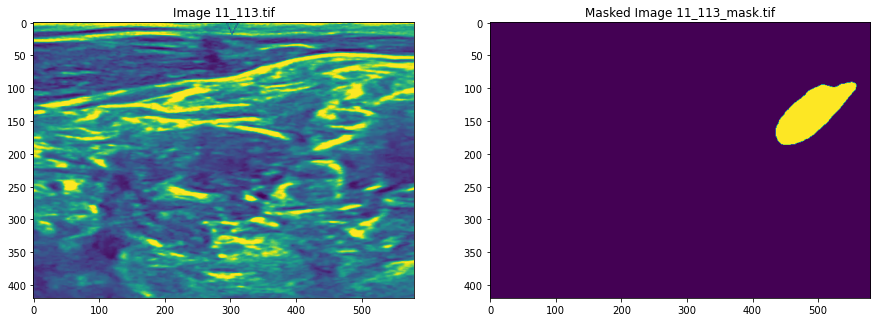

In [29]:
import imageio
path1 = 'C:/Users/shrut/OneDrive/Desktop/Shruti/Mini Project/ultrasound-nerve-segmentation/train/'
img, mask = LoadData (path1)

show_images = 134

img_view  = imageio.imread(path1 + img[show_images])
mask_view = imageio.imread(path1 + mask[show_images])

print(img_view.shape)
print(mask_view.shape)
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_view)
arr[0].set_title('Image ' + img[show_images])
arr[1].imshow(mask_view)
arr[1].set_title('Masked Image '+ mask[show_images])

In [30]:
X = np.zeros((len(train_image), 128, 128, 1), dtype=np.float32)
y = np.zeros((len(train_image), 128, 128, 1), dtype=np.float32)

In [32]:
import skimage.transform 
for n , img_name in enumerate(train_image):
  img = tf.keras.preprocessing.image.load_img('C:/Users/shrut/OneDrive/Desktop/Shruti/Mini Project/ultrasound-nerve-segmentation/train/'+img_name , grayscale=True)
  in_img = tf.keras.preprocessing.image.img_to_array(img)
  in_img = skimage.transform.resize(in_img , (128 , 128 , 1) , mode = 'constant' , preserve_range = True)
  X[n] = in_img / 255.0
  
for n , img_name in enumerate(train_mask):
  img = tf.keras.preprocessing.image.load_img('C:/Users/shrut/OneDrive/Desktop/Shruti/Mini Project/ultrasound-nerve-segmentation/train/'+img_name , grayscale=True)
  in_img = tf.keras.preprocessing.image.img_to_array(img)
  in_img = skimage.transform.resize(in_img , (128 , 128 , 1) , mode = 'constant' , preserve_range = True)
  y[n] = in_img / 255.0

In [33]:
from sklearn.model_selection import train_test_split
X_train , X_valid , y_train , y_valid = train_test_split(X , y , test_size = 0.1 , random_state = 42)

In [34]:
img_tensor = tf.keras.layers.Input((128 , 128 , 1) , name = 'img')
model = U_Net(img_tensor)
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [36]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model_nerve.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [37]:
results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/10
159/159 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9825
Epoch 1: val_loss improved from inf to 0.06438, saving model to model_nerve.h5
159/159 [==============================] - 252s 2s/step - loss: 0.1119 - accuracy: 0.9825 - val_loss: 0.0644 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 2/10
159/159 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9850
Epoch 2: val_loss improved from 0.06438 to 0.05024, saving model to model_nerve.h5
159/159 [==============================] - 249s 2s/step - loss: 0.0418 - accuracy: 0.9850 - val_loss: 0.0502 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 3/10
159/159 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9855
Epoch 3: val_loss improved from 0.05024 to 0.03462, saving model to model_nerve.h5
159/159 [==============================] - 274s 2s/step - loss: 0.0301 - accuracy: 0.9855 - val_loss: 0.0346 - val_accuracy: 0.9828 - lr: 0.0010
Epoch 4/10
159/159 [============

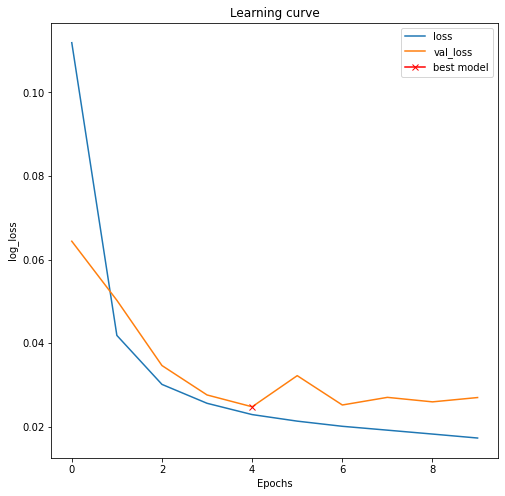

In [38]:
 plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [39]:
model.load_weights('model_nerve.h5')

In [40]:
model.evaluate(X_valid, y_valid, verbose=1)

18/18 [==============================] - 5s 258ms/step - loss: 0.0247 - accuracy: 0.9859


[0.024748237803578377, 0.9858744740486145]

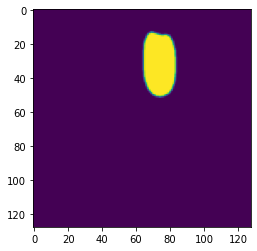

In [43]:
plt.imshow(y_valid[0].squeeze())

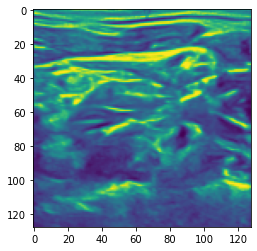

In [47]:
img_name = '1_1.tif'
img = tf.keras.preprocessing.image.load_img('C:/Users/shrut/OneDrive/Desktop/Shruti/Mini Project/ultrasound-nerve-segmentation/train/'+img_name , grayscale=True)
in_img = tf.keras.preprocessing.image.img_to_array(img)
in_img = skimage.transform.resize(in_img , (128 , 128 , 1) , mode = 'constant' , preserve_range = True)
test = in_img / 255.0
plt.imshow(test.squeeze())

In [48]:
prediction = model.predict(np.expand_dims(test , 0))

1/1 [==============================] - 0s 33ms/step


In [49]:
prediction.shape

(1, 128, 128, 1)

In [50]:
prediction.squeeze().shape

(128, 128)

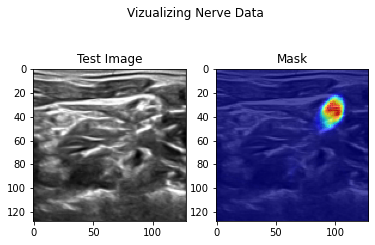

In [51]:
fig , ax = plt.subplots(1 , 2)
fig.suptitle('Vizualizing Nerve Data')
ax[0].set_title('Test Image')
ax[1].set_title('Mask')
img1 = test.squeeze()
ax[0].imshow(img1 , cmap = 'gray')

img2 = prediction.squeeze()
img2 = np.ma.masked_where(img2 == 0, img2)
ax[1].imshow(img1 , cmap = 'gray' , interpolation = 'none')
ax[1].imshow(img2 , cmap = 'jet', interpolation = 'none', alpha = 0.7)

plt.show()